# Implementation of metrics

This file demonstrates the inner workings of the essential metrics and plots used in object detection, such as AP and PR curve.

Import libraries

In [137]:
from matplotlib import pyplot as plt
import random
import numpy as np
import seaborn as sn
import pandas as pd
from pprint import pprint

from utils import draw_annotations, load_annotation

Define constants: dataset path, class names, video dimensions.

In [138]:
DATASET_PATH = "../data/yolo_datasets/blurry/42min_100random"
IMAGE_PATH = DATASET_PATH + "/images/1c5828cb-frame_172565.jpg"
LABEL_PATH = DATASET_PATH + "/labels/1c5828cb-frame_172565.txt"
CLASSES = ["ball", "paddle", "player", "player serving", "scorekeeper"]

FRAME_WIDTH = 1920
FRAME_HEIGHT = 1080

Load example image and its corresponding label. We will use an image where most of the class object boxes are present.

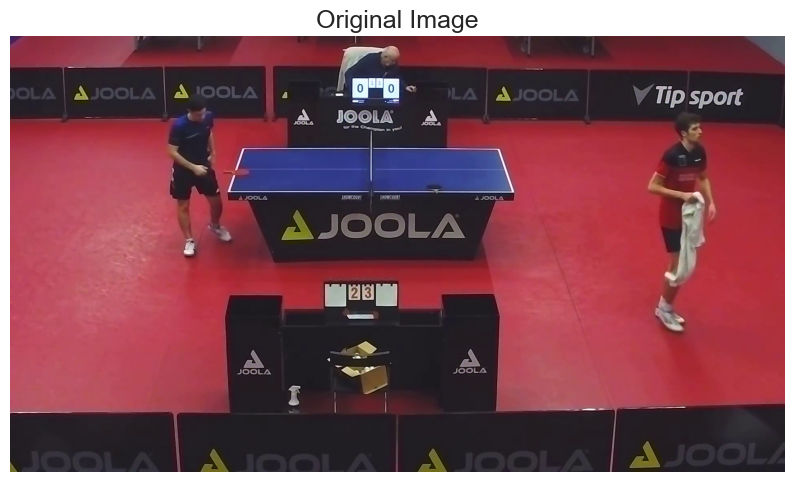

In [139]:

def display_image(img: np.ndarray, size: int = 10, title: str = ""):
    """Displays image with default plot settings"""
    plt.figure(figsize=(size, size))
    plt.axis("off")
    plt.title(title)
    plt.imshow(img)
    plt.show();

with open(IMAGE_PATH, "rb") as f:
    img = plt.imread(f)
display_image(img, title="Original Image")

In [140]:
label_annotations = load_annotation(LABEL_PATH)

for annotation in label_annotations:
    class_index = annotation[0]
    box = annotation[1:]
    print(f"{CLASSES[class_index]} box: {box}")

paddle box: [0.2900964066608238, 0.31473366442691597, 0.04031551270815076, 0.028045574057844008]
player box: [0.8654688957551933, 0.42379978576297606, 0.09553021900670323, 0.49858798325055986]
player box: [0.24276950043821202, 0.316291530271298, 0.0911481156879929, 0.3708252557491553]
scorekeeper box: [0.47808939526730937, 0.079462459830558, 0.09728308501314636, 0.12153082091732399]
paddle box: [0.5477651183172657, 0.35212776317070793, 0.022787028921998242, 0.03116174895316]


Draw the image with its label boxes.

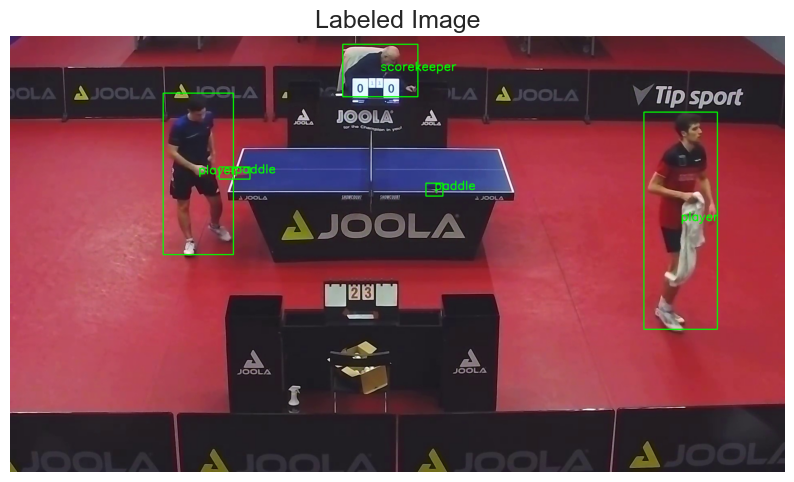

In [141]:
labeled_img = draw_annotations(img, label_annotations, CLASSES)

display_image(labeled_img, title="Labeled Image")

We will now focus only on the scorekeeper bounding box by cropping the image and displaying only its bounding.

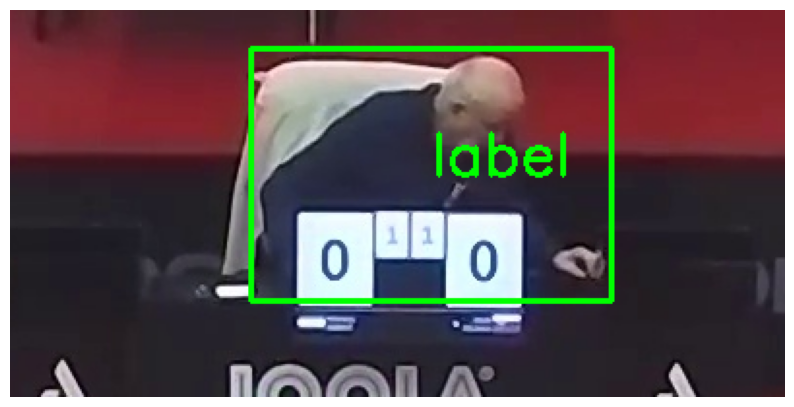

In [142]:
def draw_boxes(img: np.ndarray, boxes: list[list[float, float, float, float]], label: str = "", color: tuple[int, int, int] = (0, 255, 0), opacity: int = 1):
    """Draws boxes on the image"""
    annotations = [[0] + box for box in boxes]
    return draw_annotations(img, annotations, [label], color=color, opacity=opacity)

# Extract label box for scorekeeper
x = label_annotations[3][1]
y = label_annotations[3][2]
w = label_annotations[3][3]
h = label_annotations[3][4]
label_box = [x, y, w, h]

# Draw boxes
label_image = draw_boxes(img, [label_box], label="label")

# crop the image and display
display_image(label_image[0:200, 700:1100])

Let us now create a custom prediction that will be shifted down by one third of the ground truth's height. Other parameters will be the same.

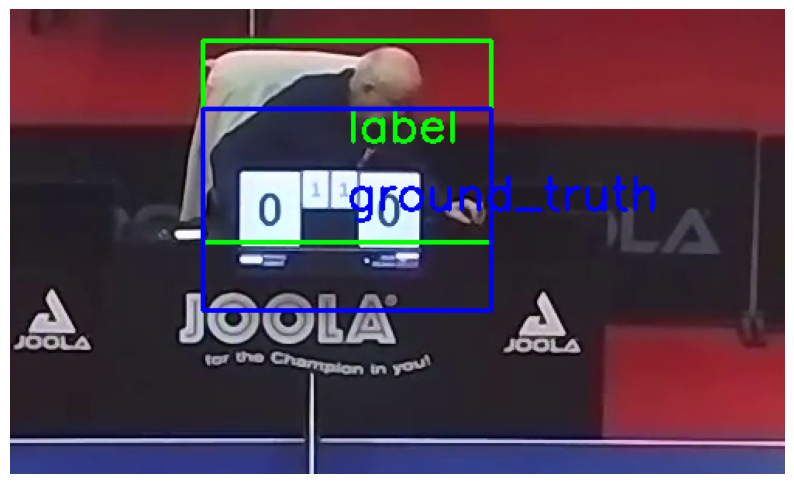

In [143]:
pred_box = [
    x,
    y + h/3,
    w,
    h
]
label_prediction_image = draw_boxes(label_image, [pred_box], "ground_truth", color=(0, 0, 255))


display_image(label_prediction_image[0:300, 700:1200])


Now, we will calculate the Intersection Over Union (IOU) between these two boxes.

In [144]:
def IOU(box1, box2):
    """Calculate IOU between two annotations"""
    cx1, cy1, w1, h1 = box1
    cx2, cy2, w2, h2 = box2

    # Get corner coordinates
    x1 = cx1 - w1 / 2
    y1 = cy1 - h1 / 2
    x2 = cx2 - w2 / 2
    y2 = cy2 - h2 / 2

    # Get intersection coordinates
    xA = max(x1, x2)
    yA = max(y1, y2)
    xB = min(x1 + w1, x2 + w2)
    yB = min(y1 + h1, y2 + h2)

    # Complete calculation
    intersection = max(0, xB - xA) * max(0, yB - yA)
    annotation1 = w1 * h1
    annotation2 = w2 * h2
    union = annotation1 + annotation2 - intersection

    return intersection / union

IOU(label_box, pred_box)

0.49999999999999933

# Core algorithm

Now, how do we actually pair a label with a prediction? Well, for each label, we compare IOU for all predictinos and choose the highest match. We can try that.


Firstly, let us define an offseted version of label. We will randomaly create a prediction box that has IOU of > 0.5 or < 0.5 with the label box.

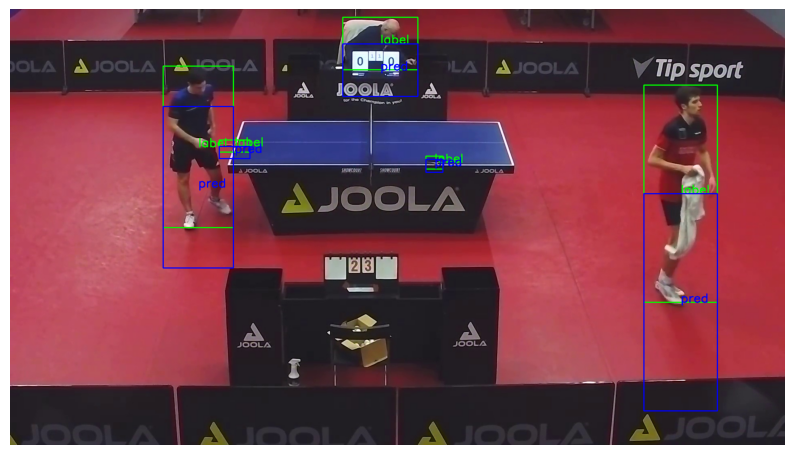

In [145]:
random.seed(1)
pred_boxes = [] 
for label in label_annotations:
    # Offset the x position down
    offset_denominator = random.choice([2,4])  # first defines box with IOU > 0.5, and second defines box with IOU < 0.5
    cx = label[1]
    cy = label[2] + label[4] / offset_denominator
    w = label[3]
    h = label[4]
    pred_boxes.append([cx, cy, w, h])

viz = draw_annotations(img, label_annotations, ["label"] * len(CLASSES))
viz = draw_boxes(viz, pred_boxes, label="pred", color=(0, 0, 255))

display_image(viz)

We will now define a threshold for IOU to be 0.5. If a label and prediction IOU is less than 0.5 then it is not a false positive. If IOU is higher than 0.5 it is true positive. For that we will define a IOU matrix defining IOUs between all predictions and all labels. We will proceed to draw the matrix of the IOU calculations.

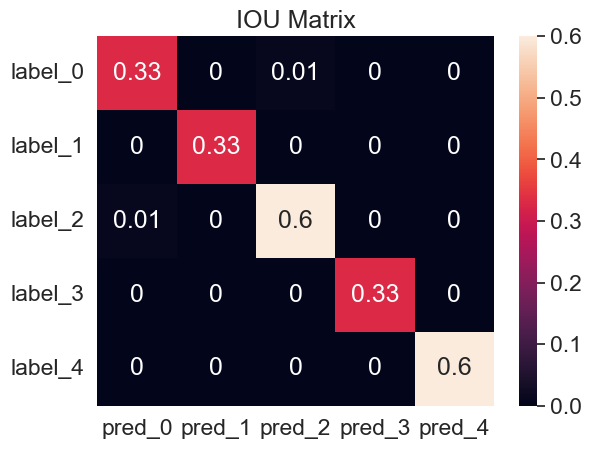

In [146]:
# IOU > threshold -> true positive
# IOU < threshold -> false positive
IOU_threshold = 0.5
label_boxes = [label[1:] for label in label_annotations]


def calculate_IOU_matrix(pred_boxes: list[float, float, float, float], label_boxes: list[float, float, float, float], display: bool = False) -> list[list[float]]:
    IOU_matrix = [[] for _ in range(len(label_boxes))]
    for i in range(len(IOU_matrix)):
        IOU_matrix[i] = [IOU(label_boxes[i], pred_box) for pred_box in pred_boxes]
    if display:
        df_cm = pd.DataFrame(IOU_matrix, ["label_" + str(i) for i in range(len(label_boxes))], ["pred_" + str(i) for i in range(len(pred_boxes))])
        df_rounded = df_cm.apply(lambda x: round(x, 2))
        sn.set_theme(font_scale=1.5) # for label size
        plt.title("IOU Matrix")
        sn.heatmap(df_rounded, annot=True)
        plt.show()

    return IOU_matrix

IOU_matrix = calculate_IOU_matrix(pred_boxes, label_boxes, display=True)


We will get the order of the label boxes sorted from highest to lowest by the highest IOU they got with any prediction box.

In [147]:
IOU_maxes = [max(IOU_matrix[i]) for i in range(len(label_boxes))]

indexed_numbers = list(enumerate(IOU_maxes))
sorted_pairs = sorted(indexed_numbers, key=lambda x: x[1], reverse=True)
IOU_max_indexes = [index for index, _ in sorted_pairs]

print(f"Highest pred IOU value for each label: {IOU_maxes}")
print(f"Sorted label box indexes: {IOU_max_indexes}")


Highest pred IOU value for each label: [0.33333333333333365, 0.33333333333333326, 0.6000000000000001, 0.333333333333333, 0.6000000000000001]
Sorted label box indexes: [2, 4, 0, 1, 3]


Calculate the number of true_positives and false_positives to get precision and recall.

In [148]:
true_positives = [False for _ in range(len(label_boxes))]  # False == false negative | for labels
false_positives = [True for _ in range(len(pred_boxes))]  # | for predictions


# Iterate in order of best matched label
for label_index in IOU_max_indexes:
    # Sort predictions IOUs with this label
    ious = enumerate(IOU_matrix[label_index])
    sorted_ious = sorted(ious, key=lambda x: x[1], reverse=True)  # for prediction[i] x current label

    # Iterate in order of best matching predictions (note that they might be taken by other labels)
    for pred_index, iou in sorted_ious:
        if iou > IOU_threshold and true_positives[label_index] is False:
            true_positives[label_index] = True
            false_positives[pred_index] = False
            break
        else:
            break

precision = sum(true_positives) / len(pred_boxes)
recall = sum(true_positives) / len(label_boxes)

print(f"Precision: {precision}, Recall: {recall}")


Precision: 0.4, Recall: 0.4


The values are the same, because we match the number of predictions exactly to the number of labels. 

We will display which box is correctly predicted and which is not. We will color the bounding boxes accordingly: <font color='blue'>the blue boxes are correctly predicted</font>, and <font color='red'>red are incorrectly predicted</font>.

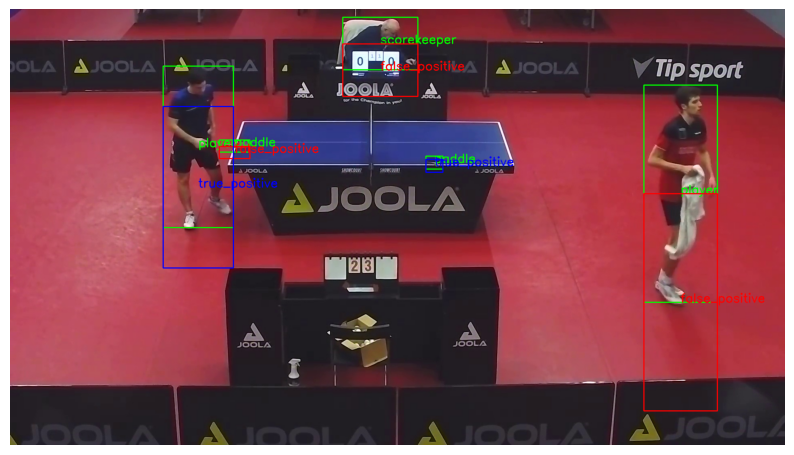

In [149]:
# Draw false positives
false_positive_boxes = [pred_boxes[i] for i in range(len(pred_boxes)) if false_positives[i]]
false_positives_image = draw_boxes(labeled_img, false_positive_boxes, "false_positive", color=(255, 0, 0))


true_positive_boxes = [pred_boxes[i] for i in range(len(pred_boxes)) if false_positives[i] is False]
all_image = draw_boxes(false_positives_image, true_positive_boxes, "true_positive", color=(0, 0, 255))

display_image(all_image)

We will enclose the precision recall into a function for repeated use. We will also create a function to automatically display the results on a supplied image. Let us color the label bounding boxes which were not matched with the color magenta. The correctly matched ones will remain green.  

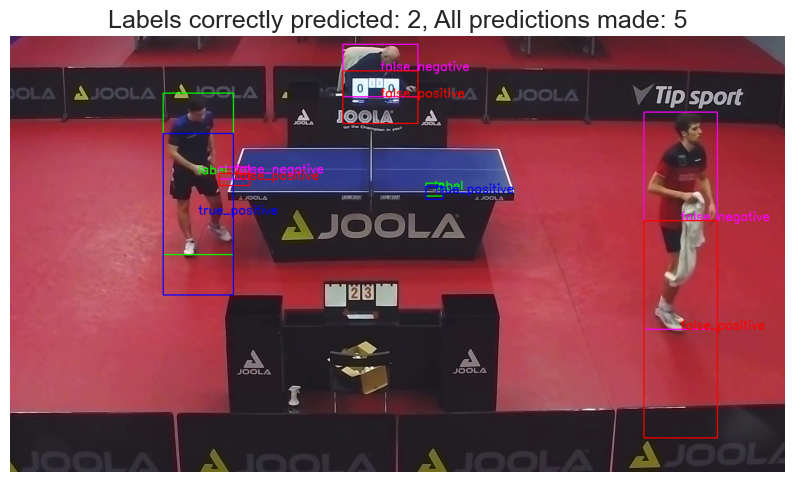

Precision: 0.4, Recall: 0.4


In [150]:
def calculate_precision_recall(pred_boxes: list[float, float, float, float], label_boxes: list[float, float, float, float], IOU_threshold: int = 0.5) -> tuple:
    # Calculate the IOU matrix
    IOU_matrix = calculate_IOU_matrix(pred_boxes, label_boxes)

    # Get label order from highest IOU to lowest
    IOU_maxes = [max(IOU_matrix[i]) for i in range(len(IOU_matrix))]
    indexed_numbers = list(enumerate(IOU_maxes))
    sorted_pairs = sorted(indexed_numbers, key=lambda x: x[1], reverse=True)
    IOU_max_indexes = [index for index, _ in sorted_pairs]


    # Initially, set all predictions to false positives
    true_positives_labels = [False for _ in range(len(label_boxes))]  # False == false negative | all labels
    false_positives_preds = [True for _ in range(len(pred_boxes))]  # | all pred_annotations

    # Iterate in order of best matched label
    for label_index in IOU_max_indexes:
        # Sort predictions IOUs with this label
        ious = enumerate(IOU_matrix[label_index])
        sorted_ious = sorted(ious, key=lambda x: x[1], reverse=True)  # for prediction[i] x current label

        # Iterate in order of best matching predictions (note that they might be taken by other labels)
        for pred_index, iou in sorted_ious:
            if iou > IOU_threshold and true_positives_labels[label_index] is False:
                true_positives_labels[label_index] = True
                false_positives_preds[pred_index] = False
                break
            else:
                break

    # Calculate precision and recall
    precision = sum(true_positives_labels) / len(pred_boxes)
    recall = sum(true_positives_labels) / len(label_boxes)

    # Select TP, FP, FN boxes. Note: there are infinitely many of true negative boxes
    true_positive_pred_boxes = [pred_boxes[i] for i in range(len(pred_boxes)) if not false_positives_preds[i]]
    true_positive_label_boxes = [label_boxes[i] for i in range(len(label_boxes)) if true_positives_labels[i]]
    false_positive_pred_boxes = [pred_boxes[i] for i in range(len(pred_boxes)) if false_positives_preds[i]]
    false_negative_label_boxes = [label_boxes[i] for i in range(len(label_boxes)) if not true_positives_labels[i]]

    return precision, recall, true_positive_pred_boxes, true_positive_label_boxes, false_positive_pred_boxes, false_negative_label_boxes


def display_precision_recall(image: np.ndarray, pred_boxes: list[float, float, float, float], label_boxes: list[float, float, float, float], IOU_threshold: float = 0.5, image_size: int = 10, title: str | None = None) -> tuple[float, float]:
    # Calculate precision, recall, and according boxes
    precision, recall, true_positive_pred_boxes, true_positive_label_boxes, false_positive_pred_boxes, false_negative_label_boxes = calculate_precision_recall(pred_boxes, label_boxes, IOU_threshold = IOU_threshold)

    # Create image with boxes
    viz = image.copy()
    viz = draw_boxes(viz, true_positive_label_boxes, "label", color=(0, 255, 0))
    viz = draw_boxes(viz, false_negative_label_boxes, "false_negative", color=(255, 0, 255))
    viz = draw_boxes(viz, false_positive_pred_boxes, "false_positive", color=(255, 0, 0))
    viz = draw_boxes(viz, true_positive_pred_boxes, "true_positive", color=(0, 0, 255))

    # Draw
    if title is None: 
        title = f"Labels correctly predicted: {len(true_positive_label_boxes)}, All predictions made: {len(true_positive_pred_boxes) + len(false_positive_pred_boxes)}"
    display_image(viz, size=image_size, title=title)

    return precision, recall

precision, recall = display_precision_recall(img, pred_boxes, label_boxes, IOU_threshold=0.5)
print(f"Precision: {precision}, Recall: {recall}")

We can also randomize the box positions randomly.

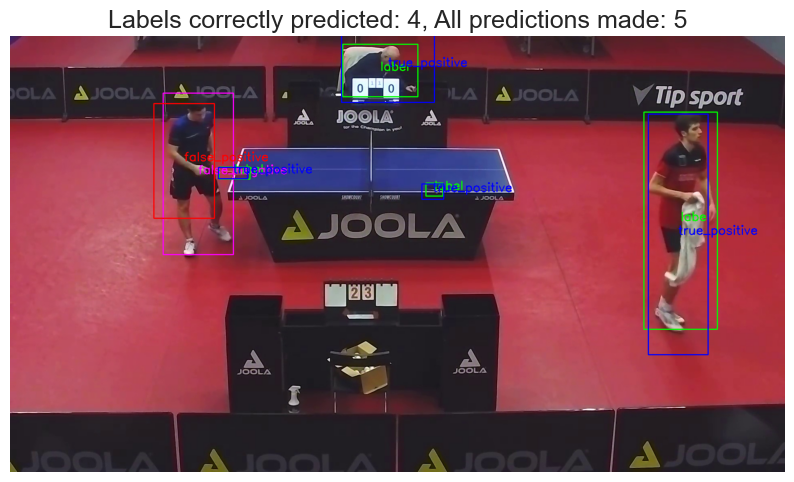

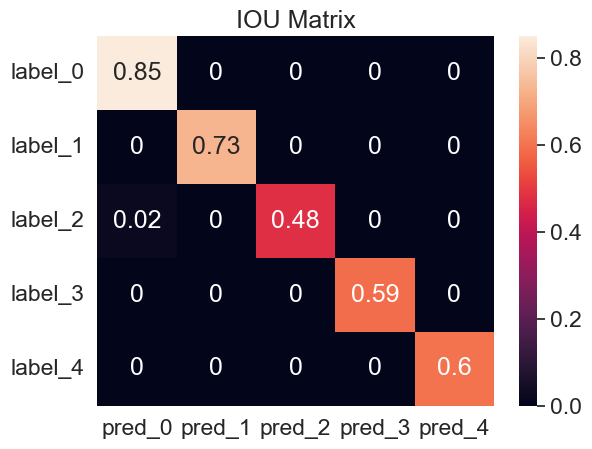

Precision: 0.8, Recall: 0.8


In [151]:
random.seed(16)
pred_boxes = [] 
for label in label_annotations:
    cx = label[1] + label[3] * random.uniform(-0.2, 0.2)
    cy = label[2] + label[4] * random.uniform(-0.2, 0.2)
    w = label[3] * random.uniform(0.6, 1.4)
    h = label[4] * random.uniform(0.6, 1.4)
    pred_boxes.append([cx, cy, w, h])
    

precision, recall = display_precision_recall(img, pred_boxes, label_boxes)
calculate_IOU_matrix(pred_boxes, label_boxes, display=True)

print(f"Precision: {precision}, Recall: {recall}")

Let us create more sophisticated prediction boxes, we will also add confidence score that simulates the confidence score from the model (we will use in future). We will add random predictions that we expect to be false positives.

Furthermore, we will define functions that extract boxes with confidence above the `confidence_threshold` and proceed with the recall, precision calculation.

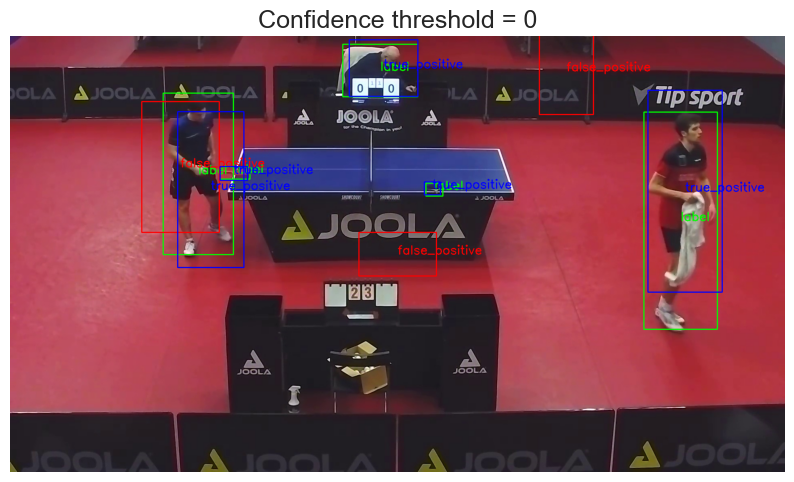

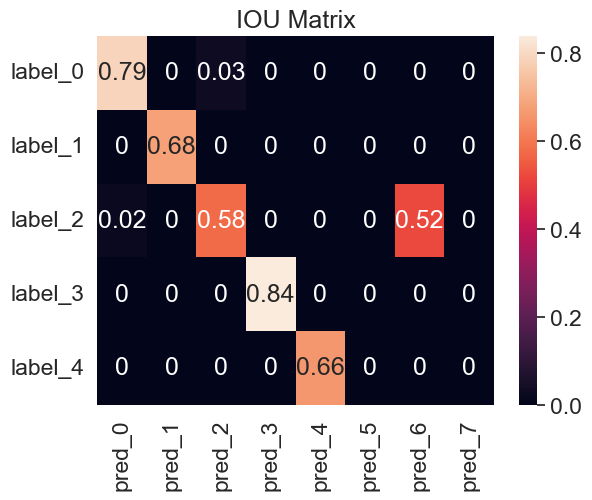

Precision: 0.62, Recall: 1.00


In [152]:
def calculate_precision_recall_confidence_prune(pred_boxes_with_confidence, label_boxes, confidence_threshold = 0.5, IOU_threshold = 0.5):
    pred_boxes = [box[1:] for box in pred_boxes_with_confidence if box[0] > confidence_threshold]
    return calculate_precision_recall(pred_boxes, label_boxes, IOU_threshold = IOU_threshold)
    
def display_precision_recall_confidence_prune(image, pred_boxes_with_confidence, label_boxes, confidence_threshold, IOU_threshold=0.5, image_size=10, title=None):
    # Filter boxes with the model predicted confidence above a threshold 
    pred_boxes = [box[1:] for box in pred_boxes_with_confidence if box[0] > confidence_threshold]
    return display_precision_recall(image, pred_boxes, label_boxes, IOU_threshold=IOU_threshold, image_size=image_size, title=title)


random.seed(10)
pred_boxes_with_confidence = [] 
for label in label_annotations:
    # x offsetted down
    offset_denominator = random.choice([2,4])
    deviations = [random.uniform(-1, 1), random.uniform(-1, 1), random.uniform(-1, 1), random.uniform(-1, 1)]
    
    confidence = sum([1 - abs(deviation) for deviation in deviations]) / len(deviations)  # smaller deviation is returns higher number
    confidence = 0.5 + 0.5 * confidence
    cx = label[1] + label[3] * deviations[0] * .2
    cy = label[2] + label[4] * deviations[1] * .2
    w = label[3] + label[3] * deviations[2] * .2
    h = label[4] + label[4] * deviations[3] * .2

    pred_boxes_with_confidence.append([confidence, cx, cy, w, h])

pred_boxes_with_confidence.append([0.3, 0.5, 0.5, 0.1, 0.1])
pred_boxes_with_confidence.append([0.4, 0.22, 0.3, 0.1, 0.3])
pred_boxes_with_confidence.append([0.2, 0.718, 0.08, 0.07, 0.2])

precision, recall = display_precision_recall_confidence_prune(img, pred_boxes_with_confidence, label_boxes, confidence_threshold=0, title="Confidence threshold = 0")
calculate_IOU_matrix([pred_box_with_confidence[1:] for pred_box_with_confidence in pred_boxes_with_confidence], label_boxes, display=True)

print(f"Precision: {precision:.2f}, Recall: {recall:.2f}")

We can see, even though, our crafted prediction box at index 6 has a IOU that satisfies our `IOU_threshold` of 0.5, there is a better prediction box (pred_2) for that label, making the prediction at index 6 a false positive. This fact is also seen in the displayed image on the player object on the left; pred_6 is red and pred_2 is blue.

Let us see the confidence scores we have generated for each prediction.

In [153]:
# Show prediction boxes based on models confidence from highest to lowest
rev = sorted(pred_boxes_with_confidence, key=lambda x: x[0], reverse=True)
for i, pred_box_with_confidence in enumerate(rev):
    confidence = pred_box_with_confidence[0]
    print(f"pred_{i} confidence: {confidence:.2f}")

pred_0 confidence: 0.85
pred_1 confidence: 0.83
pred_2 confidence: 0.82
pred_3 confidence: 0.81
pred_4 confidence: 0.77
pred_5 confidence: 0.40
pred_6 confidence: 0.30
pred_7 confidence: 0.20


Now we can visually see where the confidence threshold will separate our predictions.

# Precision-Recall (PR) curve and Average Precision (AP)
We will be replicating the process as it was done in the [Pascal Visual Object Classes (VOC)](http://host.robots.ox.ac.uk/pascal/VOC/), and [Rafael Padilla's article in 2020](https://github.com/rafaelpadilla/Object-Detection-Metrics).

The structured overview of the next cell's purpose:
- Iterate all confidence values. 
- Calculate precision and recall only with predictions exceeding this confidence threshold.
- Display predictions at each step (each iteration adds one bounding box).

**Note:** We will use the IOU_treshold to be 0.67 this time.

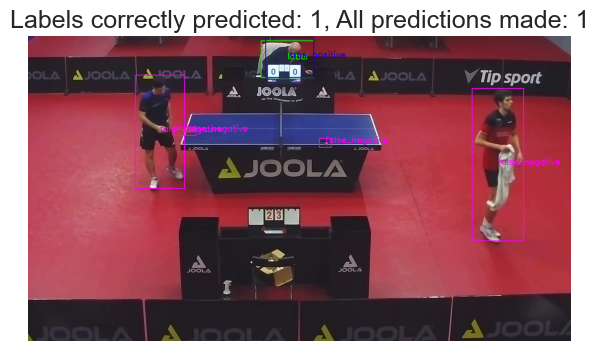

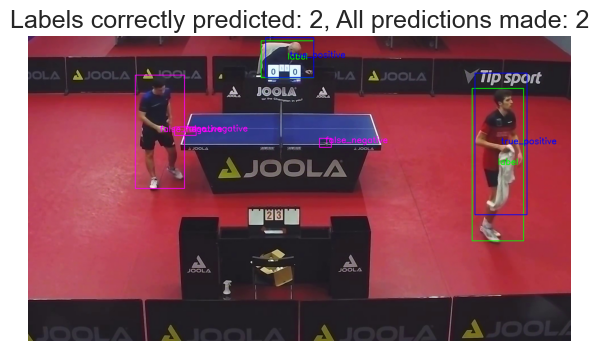

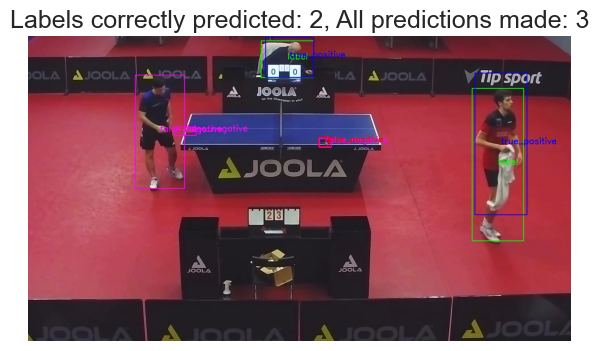

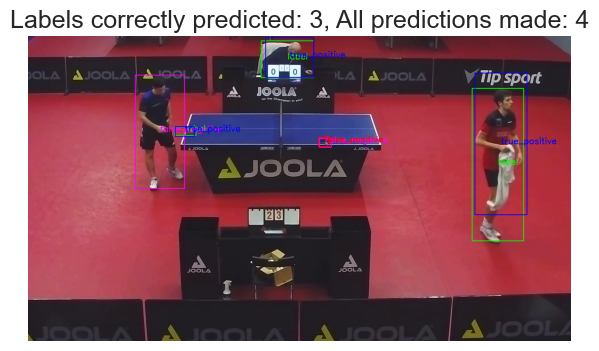

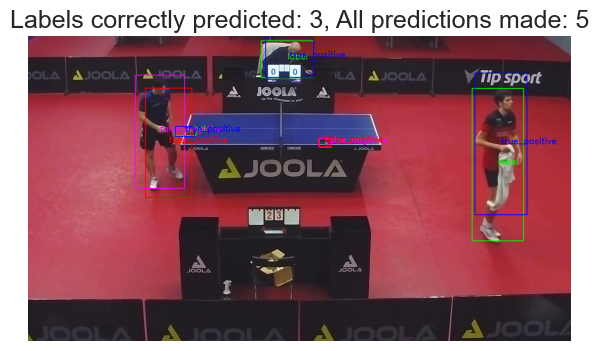

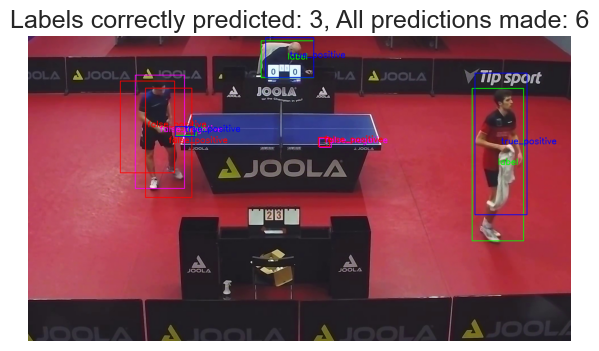

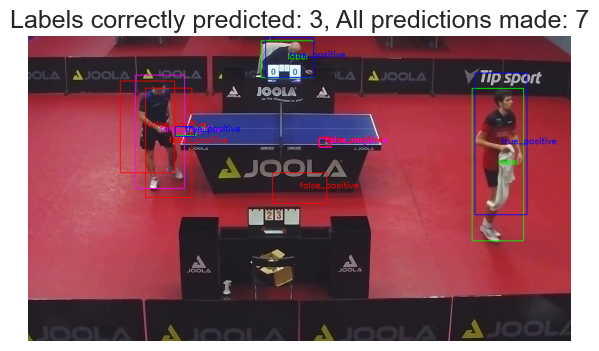

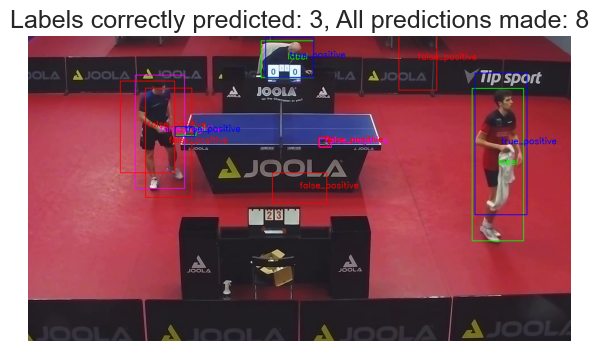

Precisions [1.0, 1.0, 0.6666666666666666, 0.75, 0.6, 0.5, 0.42857142857142855, 0.375]
Recalls [0.2, 0.4, 0.4, 0.6, 0.6, 0.6, 0.6, 0.6]


In [154]:
# Sorted confidence thresholds
confidence_thresholds = sorted([b_with_conf[0] for b_with_conf in pred_boxes_with_confidence], reverse=True)

# Calculate precision and recall at each step
precisions, recalls = [], []
for confidence_threshold in confidence_thresholds:
    confidence_threshold -= 0.001  # the first iteration will be yield one prediction box

    # Display only predictions above threshold
    precision, recall = display_precision_recall_confidence_prune(img, pred_boxes_with_confidence, label_boxes, confidence_threshold=confidence_threshold, IOU_threshold=0.67, image_size=7)

    # Save results
    precisions.append(precision)
    recalls.append(recall)

print("Precisions", precisions)
print("Recalls", recalls)

We can see that in third iteration the paddle was not correctly evaluated. The paddle bounding box is very small, hence small movements in the paddle bounding box will be penalized more than small movements with large bounding boxes. This is one of IOU's properties.

Now let us print Precision and Recall against the confidence thresholds

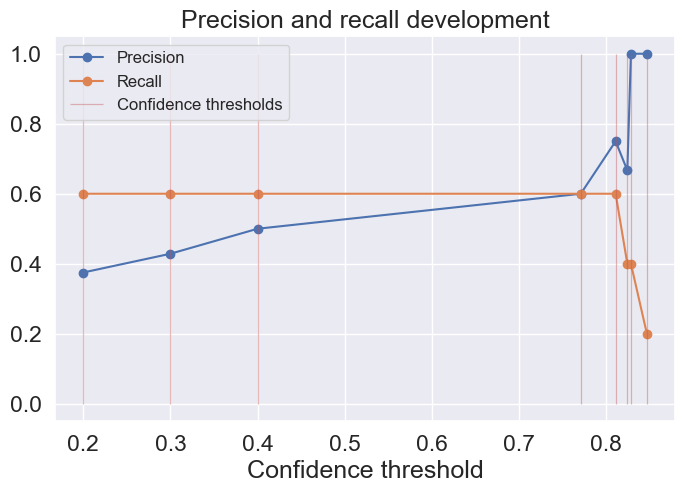

In [155]:
# Plot precision and recall against confidence threshold

plt.figure(figsize=(8, 5))
plt.plot(confidence_thresholds, precisions, label="Precision", marker="o")
plt.plot(confidence_thresholds, recalls, label="Recall", marker="o")
plt.vlines(confidence_thresholds, ymin=0, ymax=1, label="Confidence thresholds", color='r', linestyle='-', linewidth=.9, alpha=0.4)
plt.xlabel("Confidence threshold")
plt.title("Precision and recall development")
plt.legend(fontsize=12)
plt.show();

We can see that we have more boxes with higher confidence scores. 

Now is time to finally draw the Precision-Recall curve. The X axis will correspond to recall and the Y axis to precision.

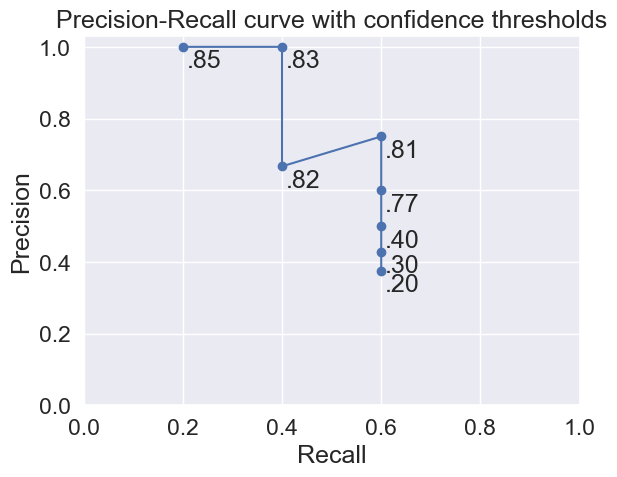

In [156]:
# Plot precision recall values against each other
plt.plot(recalls, precisions, marker="o")

# Draw confidence score next to each point
for i in range(len(recalls)):
    plt.annotate(f'{confidence_thresholds[i]:.2f}'[1:], (recalls[i], precisions[i]), textcoords="offset points", xytext=(+15,-15), ha='center')

# Configure plot and show
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall curve with confidence thresholds")
plt.ylim(0)
plt.xlim(0, 1)
plt.show()


This looks similarly to the PR curves we are used to see elsewhere. Classic PR curves do start from the top left corner and end at the top right corner. For that we will use 11 step interpolation commonly used in the older VOC challenges.

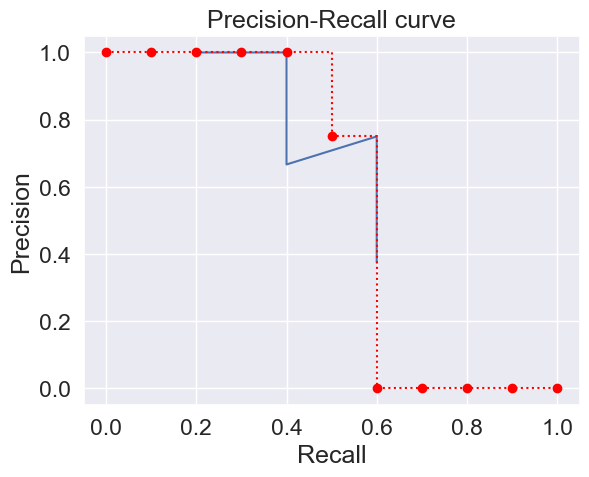

In [157]:
# Plot precision recall values
plt.plot(recalls, precisions)

#  Uniformly spaced 11-point interpolation
recall_levels = np.linspace(0, 1, 11)
interpolated_precisions = []
for interpolated_recall in recall_levels:
    # Extract highest precision at recall higher then the interpolated threshold
    interpolated_precision = max([0] + [precision for recall, precision in zip(recalls, precisions) if recall >= interpolated_recall])
    interpolated_precisions.append(interpolated_precision)

# Let us use step plot  
plt.step(recall_levels, interpolated_precisions, marker="o", where="post", linestyle="dotted", color="red")

# Configure and show the plot
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall curve")
plt.show()

This we can finally call a PR curve. 

Nowadays, the VOC datasets use newer approach to interpolation, it is all point interpolation. Instead of 11 uniformly spaced recall points it uses all the recall values that we got from prediction boxes. For example, if we have 100 predictions, we will have 100 point interpolation.

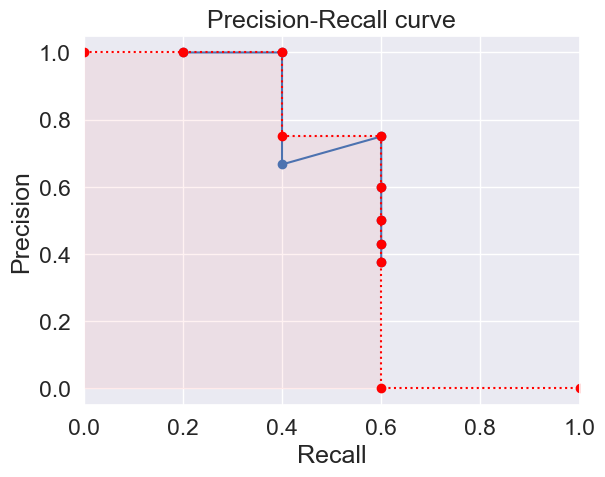

In [158]:
# Plot recall against precision
plt.plot(recalls, precisions, marker="o")

# All point interpolation
interpolated_precisions = []
for i in range(len(recalls)):
    interpolated_precision = max(precisions[i:])
    interpolated_precisions.append(interpolated_precision)

# Step plot
interpolated_recalls = [0] + recalls + [recalls[-1], 1]  # start at left top corner end at right bottom corner
interpolated_precisions = [1] + interpolated_precisions + [0, 0]  # --||--
plt.step(interpolated_recalls, interpolated_precisions, marker="o", where="post", linestyle="dotted", color="red")
# Fill area under the curve
plt.fill_between(interpolated_recalls, interpolated_precisions, step="post", color="red", alpha=0.05)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall curve")
plt.xlim(0, 1)
plt.show()

Note: We cannot plot the Receiver Operator Characteristic (ROC) curve, because for that we would need the sensitivity and specificity from the confusion matrix. Since this is a task of object detection the number of true negatives would be infinity, devaluing the significance of this curve

Let us calculate AP, it is the area under the RC curve we have just calculated.

In [159]:
# Calculate AP
prev_precision = ([1] + interpolated_precisions)[0]
prev_recall = ([0] + recalls)[0]
AP = 0  # Area under the curve
for precision, recall in zip(interpolated_precisions, interpolated_recalls):
    if prev_precision == precision:
        area = (recall - prev_recall) * (precision)
        print(f"From: {prev_recall:.1f}, To: {recall:.1f}. Area: {round(area, 2)}")
        AP += area
    
    prev_precision = precision
    prev_recall = recall
print(f"Average Precision (AP): {AP}")

From: 0.0, To: 0.0. Area: 0
From: 0.0, To: 0.2. Area: 0.2
From: 0.2, To: 0.4. Area: 0.2
From: 0.4, To: 0.6. Area: 0.15
From: 0.6, To: 1.0. Area: 0.0
Average Precision (AP): 0.55


We will now display the F1 score graph for each threshold. The F1 score effectively combines precision and recall into a single metric. 

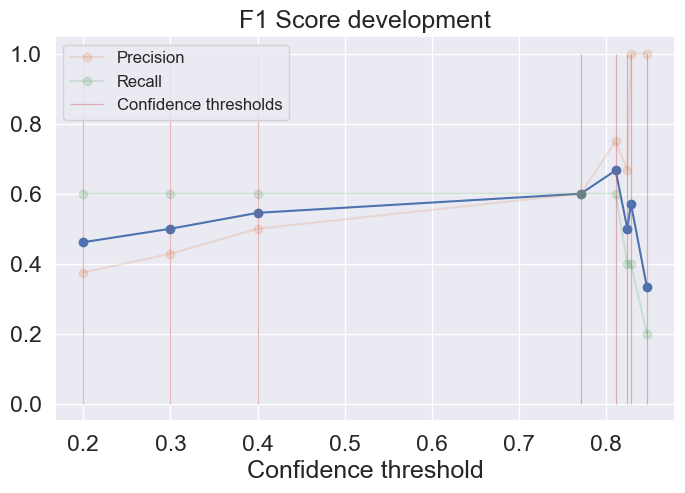

In [160]:
plt.figure(figsize=(8, 5))
F1_scores = [2 * precision * recall / (precision + recall) for precision, recall in zip(precisions, recalls)]
plt.plot(confidence_thresholds, F1_scores, marker="o")

# Plot precision and recall against confidence threshold

plt.plot(confidence_thresholds, precisions, label="Precision", marker="o", alpha=0.2)
plt.plot(confidence_thresholds, recalls, label="Recall", marker="o", alpha=0.2)
plt.vlines(confidence_thresholds, ymin=0, ymax=1, label="Confidence thresholds", color='r', linestyle='-', linewidth=.9, alpha=0.4)
plt.xlabel("Confidence threshold")
plt.title("F1 Score development")
plt.legend(fontsize=12)
plt.show();

The mean Average Precision (mAP) would be calculated by separating predicted classes, calculating AP, and then averaging all AP scores for each class.